# Proyecto AREP - Asistente de enfermería integrado con dispositivos IoT

Juan Esteban Cancelado


Samuel Alejandro Prieto


Juan José Díaz

## Sistema Inteligente de Monitoreo de Salud con Dispositivos Wearables

Este proyecto integra tecnologías de Inteligencia Artificial para analizar datos de salud de dispositivos wearables (relojes y pulseras inteligentes), proporcionando:

- 🤖 **Análisis inteligente** con modelos de IA (OpenAI GPT-4)
- 📊 **Visualizaciones interactivas** de tendencias de salud
- 🚨 **Sistema de alertas** automático para valores críticos
- 💬 **Agente conversacional** con memoria contextual
- 📄 **Reportes médicos en PDF** profesionales
- 💾 **Base de datos** para historial completo

---

**IMPORTANTE:** Esta es una IA de asistencia. No sustituye la consulta médica profesional.

---

### 🎯 Objetivos del Proyecto

1. Demostrar integración de **LangChain** con APIs de IA
2. Aplicar **análisis de datos de salud** en tiempo real
3. Implementar **arquitectura modular** escalable
4. Crear sistema de **alertas inteligentes**
5. Generar **reportes profesionales** automatizados

## Instalación de Dependencias

Primero instalamos todas las librerías necesarias para el proyecto:

In [35]:
# Instalación de todas las dependencias necesarias
!pip install -q langchain langchain-openai langchain-community python-dotenv matplotlib plotly pandas reportlab nbformat

## Configuración Inicial

Importamos las librerías necesarias y configuramos el entorno:

In [36]:
# Imports principales
import os
import random
import json
import sqlite3
from datetime import datetime, timedelta
from typing import List, Dict, Callable
from enum import Enum
from dataclasses import dataclass

from dotenv import load_dotenv

from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Legacy chains/memory
from langchain_classic.chains import LLMChain, ConversationChain
from langchain_classic.memory import ConversationBufferMemory

# Visualización
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PDF
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.enums import TA_CENTER, TA_LEFT

# Cargar variables de entorno
# Buscar el archivo .env en el directorio del notebook
import pathlib
notebook_dir = pathlib.Path().absolute()
env_path = notebook_dir / '.env'

# Cargar con ruta explícita
load_dotenv(dotenv_path=env_path)

print("Librerías importadas correctamente")
print(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Directorio del notebook: {notebook_dir}")
print(f"Archivo .env: {'Encontrado' if env_path.exists() else 'No encontrado'}")
if env_path.exists():
    print(f"   Ubicación: {env_path}")

Librerías importadas correctamente
Fecha: 2025-12-11 21:33:39
Directorio del notebook: c:\Users\juanj\Downloads\jupyterguides\jupyterguides\Proyecto
Archivo .env: Encontrado
   Ubicación: c:\Users\juanj\Downloads\jupyterguides\jupyterguides\Proyecto\.env


## Configuración de API Key (Opcional)

Para usar las funcionalidades de IA, crea un archivo `.env` en este directorio con tu API key de OpenAI:

```
OPENAI_API_KEY=tu_clave_aqui
```

**Nota:** El sistema funcionará sin API key, pero sin las capacidades de análisis con IA.

---

# PARTE 1: Componentes Básicos del Sistema

En esta sección construimos los componentes fundamentales del sistema de monitoreo de salud.

## Clase WearableData - Modelo de Datos de Salud

Esta clase representa los datos que obtenemos de un dispositivo wearable (reloj o pulsera inteligente).

In [37]:
class WearableData:
    """
    Clase para representar datos de dispositivos wearables.
    
    Atributos:
        frecuencia_cardiaca (int): Latidos por minuto (bpm)
        presion_sistolica (int): Presión arterial sistólica (mmHg)
        presion_diastolica (int): Presión arterial diastólica (mmHg)
        nivel_oxigeno (int): Saturación de oxígeno en sangre (%)
        pasos (int): Número de pasos dados
        calorias (int): Calorías quemadas
        horas_sueno (float): Horas de sueño
    """
    
    def __init__(self, frecuencia_cardiaca, presion_sistolica, presion_diastolica, 
                 nivel_oxigeno, pasos, calorias, horas_sueno):
        self.frecuencia_cardiaca = frecuencia_cardiaca  # bpm
        self.presion_sistolica = presion_sistolica      # mmHg
        self.presion_diastolica = presion_diastolica    # mmHg
        self.nivel_oxigeno = nivel_oxigeno              # %
        self.pasos = pasos
        self.calorias = calorias
        self.horas_sueno = horas_sueno
        self.timestamp = datetime.now()
    
    def to_dict(self):
        """Convierte los datos a un diccionario para fácil visualización"""
        return {
            'frecuencia_cardiaca': self.frecuencia_cardiaca,
            'presion': f'{self.presion_sistolica}/{self.presion_diastolica}',
            'nivel_oxigeno': self.nivel_oxigeno,
            'pasos': self.pasos,
            'calorias': self.calorias,
            'horas_sueno': self.horas_sueno,
            'timestamp': self.timestamp.strftime('%Y-%m-%d %H:%M:%S')
        }

# Ejemplo de uso
datos_ejemplo = WearableData(
    frecuencia_cardiaca=75,
    presion_sistolica=120,
    presion_diastolica=80,
    nivel_oxigeno=98,
    pasos=8500,
    calorias=2000,
    horas_sueno=7.5
)

print("Ejemplo de datos de wearable:")
print(json.dumps(datos_ejemplo.to_dict(), indent=2, ensure_ascii=False))

Ejemplo de datos de wearable:
{
  "frecuencia_cardiaca": 75,
  "presion": "120/80",
  "nivel_oxigeno": 98,
  "pasos": 8500,
  "calorias": 2000,
  "horas_sueno": 7.5,
  "timestamp": "2025-12-11 21:33:50"
}


## Configuración del Modelo de IA con LangChain

Configuramos el modelo de lenguaje GPT-4 de OpenAI para análisis inteligente de datos de salud.

In [38]:
# Configurar el modelo de OpenAI
api_key = os.getenv('OPENAI_API_KEY')

if api_key and api_key.strip():
    try:
        llm = ChatOpenAI(
            model="gpt-4",
            temperature=0.3,  # Baja temperatura para respuestas más precisas en temas médicos
            api_key=api_key
        )
        # Probar que funciona haciendo una llamada simple
        print("Modelo de IA configurado correctamente")
        print(" Modelo: GPT-4")
        print(" Temperatura: 0.3 (respuestas precisas)")
        print(f" API Key: ...{api_key[-4:]}")
    except Exception as e:
        print("No se pudo configurar el modelo de IA")
        print(f"   Error: {e}")
        print("   El sistema funcionará sin capacidades de IA")
        llm = None
else:
    print("   No se encontró OPENAI_API_KEY en el archivo .env")
    print("   El sistema funcionará sin capacidades de IA")
    print("   Crea un archivo .env con: OPENAI_API_KEY=tu_clave_aqui")
    llm = None

Modelo de IA configurado correctamente
 Modelo: GPT-4
 Temperatura: 0.3 (respuestas precisas)
 API Key: ...NkgA


## Template de Prompts para Análisis Médico

Creamos un template especializado usando LangChain para que la IA analice datos de salud de forma estructurada.

In [39]:
template_analisis = """
Eres un asistente médico virtual especializado en análisis de datos de salud de dispositivos wearables.

IMPORTANTE: No sustituyes a un médico profesional. Tus recomendaciones son orientativas y educativas.

Analiza los siguientes datos de un dispositivo wearable:

DATOS ACTUALES:
- Frecuencia Cardíaca: {frecuencia_cardiaca} bpm
- Presión Arterial: {presion_sistolica}/{presion_diastolica} mmHg
- Nivel de Oxígeno: {nivel_oxigeno}%
- Pasos del día: {pasos}
- Calorías consumidas: {calorias}
- Horas de sueño: {horas_sueno}

Por favor proporciona un análisis estructurado con:

1. **Estado General**: Evaluación general de los indicadores vitales
2. **Alertas**: Identifica valores fuera del rango normal
3. **Consejos Prácticos**: Recomendaciones de estilo de vida específicas
4. **Nivel de Urgencia**: Clasifica como BAJO / MEDIO / ALTO
   - BAJO: Valores normales, continuar con hábitos saludables
   - MEDIO: Valores en el límite, monitorear y ajustar hábitos
   - ALTO: Valores preocupantes, consultar con médico

Respuesta:
"""

prompt = PromptTemplate(
    input_variables=[
        'frecuencia_cardiaca', 'presion_sistolica', 'presion_diastolica',
        'nivel_oxigeno', 'pasos', 'calorias', 'horas_sueno'
    ],
    template=template_analisis
)

print("Template de análisis médico creado")
print("Variables: Frecuencia cardíaca, presión arterial, oxígeno, actividad, sueño")

Template de análisis médico creado
Variables: Frecuencia cardíaca, presión arterial, oxígeno, actividad, sueño


## Agente de Análisis de Salud

Creamos el agente que combina el modelo de IA con el template de análisis médico.

In [40]:
# Crear la cadena de LangChain (solo si el LLM está disponible)
if llm:
    agente_salud = LLMChain(llm=llm, prompt=prompt)
    
    def analizar_datos_salud(datos_wearable: WearableData) -> str:
        """
        Analiza datos de salud usando IA.
        
        Args:
            datos_wearable: Objeto WearableData con los datos a analizar
            
        Returns:
            Análisis textual generado por la IA
        """
        try:
            resultado = agente_salud.run(
                frecuencia_cardiaca=datos_wearable.frecuencia_cardiaca,
                presion_sistolica=datos_wearable.presion_sistolica,
                presion_diastolica=datos_wearable.presion_diastolica,
                nivel_oxigeno=datos_wearable.nivel_oxigeno,
                pasos=datos_wearable.pasos,
                calorias=datos_wearable.calorias,
                horas_sueno=datos_wearable.horas_sueno
            )
            return resultado
        except Exception as e:
            return f"Error al analizar datos: {e}"
    
    print(" Agente de salud creado y listo para analizar datos")
else:
    def analizar_datos_salud(datos_wearable: WearableData) -> str:
        return " Agente de IA no disponible. Configure OPENAI_API_KEY para usar esta funcionalidad."
    
    print(" Agente de salud en modo limitado (sin IA)")

 Agente de salud creado y listo para analizar datos


## Ejemplos de Análisis

Probamos el agente con diferentes escenarios de datos de salud.

In [41]:
# Caso 1: Presión arterial elevada y poco sueño
caso_1 = WearableData(
    frecuencia_cardiaca=85,
    presion_sistolica=140,
    presion_diastolica=95,
    nivel_oxigeno=97,
    pasos=3500,
    calorias=1800,
    horas_sueno=5.5
)

print("=" * 80)
print("CASO 1: PRESIÓN ALTA Y SUEÑO INSUFICIENTE")
print("=" * 80)
print(f"\n Datos del paciente:")
print(json.dumps(caso_1.to_dict(), indent=2, ensure_ascii=False))
print("\n" + "=" * 80)
print(" ANÁLISIS DEL AGENTE DE IA:")
print("=" * 80)
analisis_1 = analizar_datos_salud(caso_1)
print(analisis_1)

CASO 1: PRESIÓN ALTA Y SUEÑO INSUFICIENTE

 Datos del paciente:
{
  "frecuencia_cardiaca": 85,
  "presion": "140/95",
  "nivel_oxigeno": 97,
  "pasos": 3500,
  "calorias": 1800,
  "horas_sueno": 5.5,
  "timestamp": "2025-12-11 21:34:36"
}

 ANÁLISIS DEL AGENTE DE IA:
1. **Estado General**: Los indicadores vitales muestran que la frecuencia cardíaca y el nivel de oxígeno están dentro del rango normal. Sin embargo, la presión arterial está elevada y los datos de actividad y sueño indican un estilo de vida sedentario y un sueño insuficiente.

2. **Alertas**: La presión arterial de 140/95 mmHg está en el rango de hipertensión de etapa 1, lo cual es una preocupación. Además, el número de pasos del día está por debajo de la recomendación general de 10,000 pasos. Las calorías consumidas parecen estar dentro de un rango normal, dependiendo de su nivel de actividad y factores individuales. Sin embargo, las horas de sueño están por debajo de la recomendación general de 7-9 horas de sueño por noc

In [42]:
# Caso 2: Valores saludables
caso_2 = WearableData(
    frecuencia_cardiaca=72,
    presion_sistolica=120,
    presion_diastolica=80,
    nivel_oxigeno=98,
    pasos=10000,
    calorias=2200,
    horas_sueno=7.5
)

print("\n" + "=" * 80)
print("CASO 2: VALORES SALUDABLES")
print("=" * 80)
print(f"\n Datos del paciente:")
print(json.dumps(caso_2.to_dict(), indent=2, ensure_ascii=False))
print("\n" + "=" * 80)
print(" ANÁLISIS DEL AGENTE DE IA:")
print("=" * 80)
analisis_2 = analizar_datos_salud(caso_2)
print(analisis_2)


CASO 2: VALORES SALUDABLES

 Datos del paciente:
{
  "frecuencia_cardiaca": 72,
  "presion": "120/80",
  "nivel_oxigeno": 98,
  "pasos": 10000,
  "calorias": 2200,
  "horas_sueno": 7.5,
  "timestamp": "2025-12-11 21:35:20"
}

 ANÁLISIS DEL AGENTE DE IA:
1. **Estado General**: Los indicadores vitales parecen estar en un rango normal y saludable. La frecuencia cardíaca está dentro del rango normal de 60-100 bpm para un adulto en reposo. La presión arterial es ideal, y el nivel de oxígeno en sangre es excelente, ya que cualquier valor por encima del 95% se considera normal. Los pasos del día cumplen con la recomendación de la OMS de 10,000 pasos diarios. Las calorías consumidas están dentro del rango promedio para un adulto y las horas de sueño también se encuentran dentro del rango recomendado de 7-9 horas.

2. **Alertas**: No se identifican valores fuera del rango normal.

3. **Consejos Prácticos**: Mantén un estilo de vida activo, sigue haciendo ejercicio regularmente y mantén una die

## Sistema de Alertas Automáticas (Pre-filtrado)

Sistema básico que identifica valores críticos antes del análisis de IA.

In [43]:
def verificar_alertas(datos: WearableData) -> List[str]:
    """
    Sistema de pre-filtrado de alertas críticas basado en umbrales médicos.
    
    Args:
        datos: Objeto WearableData a evaluar
        
    Returns:
        Lista de alertas detectadas
    """
    alertas = []
    
    # Frecuencia cardíaca
    if datos.frecuencia_cardiaca > 100 or datos.frecuencia_cardiaca < 60:
        alertas.append(f" Frecuencia cardíaca fuera de rango: {datos.frecuencia_cardiaca} bpm")
    
    # Presión arterial
    if datos.presion_sistolica >= 140 or datos.presion_diastolica >= 90:
        alertas.append(f" Presión arterial elevada: {datos.presion_sistolica}/{datos.presion_diastolica} mmHg")
    elif datos.presion_sistolica < 90 or datos.presion_diastolica < 60:
        alertas.append(f" Presión arterial baja: {datos.presion_sistolica}/{datos.presion_diastolica} mmHg")
    
    # Nivel de oxígeno
    if datos.nivel_oxigeno < 95:
        alertas.append(f" Nivel de oxígeno bajo: {datos.nivel_oxigeno}%")
    
    # Sueño
    if datos.horas_sueno < 6:
        alertas.append(f" Sueño insuficiente: {datos.horas_sueno} horas")
    
    # Actividad física
    if datos.pasos < 5000:
        alertas.append(f" Actividad física baja: {datos.pasos} pasos")
    
    return alertas

# Probar sistema de alertas
print(" SISTEMA DE ALERTAS AUTOMÁTICAS\n")
alertas_caso1 = verificar_alertas(caso_1)
print(f"Caso 1 - Alertas detectadas: {len(alertas_caso1)}")
for alerta in alertas_caso1:
    print(f"  {alerta}")

print()
alertas_caso2 = verificar_alertas(caso_2)
print(f"Caso 2 - Alertas detectadas: {len(alertas_caso2)}")
if alertas_caso2:
    for alerta in alertas_caso2:
        print(f"  {alerta}")
else:
    print("  Todos los valores en rango normal")

 SISTEMA DE ALERTAS AUTOMÁTICAS

Caso 1 - Alertas detectadas: 3
   Presión arterial elevada: 140/95 mmHg
   Sueño insuficiente: 5.5 horas
   Actividad física baja: 3500 pasos

Caso 2 - Alertas detectadas: 0
  Todos los valores en rango normal


---

#  PARTE 2: Componentes Avanzados del Sistema

En esta sección implementamos las funcionalidades avanzadas: API de wearables, base de datos, visualizaciones, agente conversacional, notificaciones y reportes PDF.

## Integración con API Simulada de Wearables

Simulación de una API REST como Fitbit o Apple Health para obtener datos de dispositivos.

In [44]:
import random
import json
from typing import List, Dict

class WearableAPI:
    """Simulación de API de dispositivo wearable"""
    
    def __init__(self, user_id: str):
        self.user_id = user_id
        self.device_type = random.choice(["Fitbit", "Apple Watch", "Garmin", "Samsung Galaxy Watch"])
    
    def get_realtime_data(self) -> WearableData:
        """Simula obtener datos en tiempo real del dispositivo"""
        return WearableData(
            frecuencia_cardiaca=random.randint(60, 100),
            presion_sistolica=random.randint(110, 145),
            presion_diastolica=random.randint(70, 95),
            nivel_oxigeno=random.randint(95, 100),
            pasos=random.randint(1000, 15000),
            calorias=random.randint(1500, 2500),
            horas_sueno=round(random.uniform(4.5, 9.0), 1)
        )
    
    def get_historical_data(self, days: int = 7) -> List[WearableData]:
        """Simula obtener datos históricos"""
        return [self.get_realtime_data() for _ in range(days)]
    
    def get_device_info(self) -> Dict:
        """Información del dispositivo"""
        return {
            "user_id": self.user_id,
            "device": self.device_type,
            "battery": f"{random.randint(20, 100)}%",
            "last_sync": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

# Probar la API
api = WearableAPI(user_id="user_12345")
print("=== INFORMACIÓN DEL DISPOSITIVO ===")
print(json.dumps(api.get_device_info(), indent=2))
print("\n=== DATOS EN TIEMPO REAL ===")
datos_real_time = api.get_realtime_data()
print(datos_real_time.to_dict())

=== INFORMACIÓN DEL DISPOSITIVO ===
{
  "user_id": "user_12345",
  "device": "Garmin",
  "battery": "72%",
  "last_sync": "2025-12-11 21:36:11"
}

=== DATOS EN TIEMPO REAL ===
{'frecuencia_cardiaca': 87, 'presion': '113/90', 'nivel_oxigeno': 97, 'pasos': 13575, 'calorias': 1531, 'horas_sueno': 6.0, 'timestamp': '2025-12-11 21:36:11'}


## Base de Datos para Historial de Mediciones

Sistema de almacenamiento persistente con SQLite para guardar todo el historial de datos de salud.

In [45]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta

class HealthDatabase:
    """Gestor de base de datos para historial de salud"""
    
    def __init__(self, db_name: str = "health_data.db"):
        self.db_name = db_name
        self.create_tables()
    
    def create_tables(self):
        """Crear tablas si no existen"""
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS mediciones (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                user_id TEXT,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
                frecuencia_cardiaca INTEGER,
                presion_sistolica INTEGER,
                presion_diastolica INTEGER,
                nivel_oxigeno INTEGER,
                pasos INTEGER,
                calorias INTEGER,
                horas_sueno REAL
            )
        ''')
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS analisis (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                medicion_id INTEGER,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
                analisis_completo TEXT,
                nivel_urgencia TEXT,
                FOREIGN KEY (medicion_id) REFERENCES mediciones (id)
            )
        ''')
        
        conn.commit()
        conn.close()
    
    def guardar_medicion(self, user_id: str, datos: WearableData) -> int:
        """Guardar una medición en la base de datos"""
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT INTO mediciones 
            (user_id, frecuencia_cardiaca, presion_sistolica, presion_diastolica,
             nivel_oxigeno, pasos, calorias, horas_sueno)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (user_id, datos.frecuencia_cardiaca, datos.presion_sistolica,
              datos.presion_diastolica, datos.nivel_oxigeno, datos.pasos,
              datos.calorias, datos.horas_sueno))
        
        medicion_id = cursor.lastrowid
        conn.commit()
        conn.close()
        
        return medicion_id
    
    def guardar_analisis(self, medicion_id: int, analisis: str, urgencia: str):
        """Guardar análisis de IA"""
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT INTO analisis (medicion_id, analisis_completo, nivel_urgencia)
            VALUES (?, ?, ?)
        ''', (medicion_id, analisis, urgencia))
        
        conn.commit()
        conn.close()
    
    def obtener_historial(self, user_id: str, dias: int = 30) -> pd.DataFrame:
        """Obtener historial de mediciones"""
        conn = sqlite3.connect(self.db_name)
        
        query = f'''
            SELECT * FROM mediciones 
            WHERE user_id = ? 
            AND timestamp >= datetime('now', '-{dias} days')
            ORDER BY timestamp DESC
        '''
        
        df = pd.read_sql_query(query, conn, params=(user_id,))
        conn.close()
        
        return df
    
    def obtener_estadisticas(self, user_id: str) -> Dict:
        """Calcular estadísticas del usuario"""
        df = self.obtener_historial(user_id, dias=30)
        
        if df.empty:
            return {}
        
        return {
            'frecuencia_cardiaca_promedio': df['frecuencia_cardiaca'].mean(),
            'presion_sistolica_promedio': df['presion_sistolica'].mean(),
            'presion_diastolica_promedio': df['presion_diastolica'].mean(),
            'pasos_promedio': df['pasos'].mean(),
            'horas_sueno_promedio': df['horas_sueno'].mean(),
            'total_mediciones': len(df)
        }

# Probar la base de datos
db = HealthDatabase()

# Guardar una medición
medicion_id = db.guardar_medicion("user_12345", caso_1)
print(f"✅ Medición guardada con ID: {medicion_id}")

# Ver estadísticas
stats = db.obtener_estadisticas("user_12345")
print("\n=== ESTADÍSTICAS ===")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

✅ Medición guardada con ID: 655

=== ESTADÍSTICAS ===
frecuencia_cardiaca_promedio: 79.30
presion_sistolica_promedio: 125.99
presion_diastolica_promedio: 82.29
pasos_promedio: 7780.18
horas_sueno_promedio: 6.89
total_mediciones: 634


## Visualizaciones con Matplotlib y Plotly

Gráficas interactivas de tendencias de salud para análisis visual de datos.

In [46]:
# Instalación de librerías de visualización
!pip install matplotlib plotly pandas

Defaulting to user installation because normal site-packages is not writeable


In [47]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class HealthVisualizer:
    """Generador de gráficas para datos de salud"""
    
    def __init__(self, db: HealthDatabase, user_id: str):
        self.db = db
        self.user_id = user_id
    
    def generar_datos_ejemplo(self, dias: int = 30):
        """Generar datos de ejemplo para visualización"""
        for i in range(dias):
            datos = WearableData(
                frecuencia_cardiaca=random.randint(60, 95),
                presion_sistolica=random.randint(110, 140),
                presion_diastolica=random.randint(70, 90),
                nivel_oxigeno=random.randint(95, 100),
                pasos=random.randint(3000, 12000),
                calorias=random.randint(1800, 2400),
                horas_sueno=round(random.uniform(5.5, 8.5), 1)
            )
            self.db.guardar_medicion(self.user_id, datos)
    
    def grafica_frecuencia_cardiaca(self):
        """Gráfica de tendencia de frecuencia cardíaca"""
        df = self.db.obtener_historial(self.user_id)
        
        if df.empty:
            print("No hay datos disponibles")
            return
        
        plt.figure(figsize=(12, 5))
        plt.plot(df['timestamp'], df['frecuencia_cardiaca'], marker='o', linestyle='-', color='#e74c3c')
        plt.axhline(y=60, color='green', linestyle='--', alpha=0.3, label='Límite inferior normal')
        plt.axhline(y=100, color='orange', linestyle='--', alpha=0.3, label='Límite superior normal')
        plt.xlabel('Fecha')
        plt.ylabel('Frecuencia Cardíaca (bpm)')
        plt.title('Tendencia de Frecuencia Cardíaca - Últimos 30 días')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def grafica_presion_arterial(self):
        """Gráfica de presión arterial"""
        df = self.db.obtener_historial(self.user_id)
        
        if df.empty:
            print("No hay datos disponibles")
            return
        
        plt.figure(figsize=(12, 5))
        plt.plot(df['timestamp'], df['presion_sistolica'], marker='o', label='Sistólica', color='#3498db')
        plt.plot(df['timestamp'], df['presion_diastolica'], marker='s', label='Diastólica', color='#9b59b6')
        plt.axhline(y=120, color='green', linestyle='--', alpha=0.3)
        plt.axhline(y=140, color='orange', linestyle='--', alpha=0.3)
        plt.xlabel('Fecha')
        plt.ylabel('Presión Arterial (mmHg)')
        plt.title('Tendencia de Presión Arterial - Últimos 30 días')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def dashboard_interactivo(self):
        """Dashboard interactivo con Plotly"""
        df = self.db.obtener_historial(self.user_id)
        
        if df.empty:
            print("No hay datos disponibles")
            return
        
        # Crear subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Frecuencia Cardíaca', 'Presión Arterial', 
                          'Actividad Física', 'Calidad del Sueño'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # Gráfica 1: Frecuencia Cardíaca
        fig.add_trace(
            go.Scatter(x=df['timestamp'], y=df['frecuencia_cardiaca'], 
                      mode='lines+markers', name='FC',
                      line=dict(color='#e74c3c', width=2)),
            row=1, col=1
        )
        
        # Gráfica 2: Presión Arterial
        fig.add_trace(
            go.Scatter(x=df['timestamp'], y=df['presion_sistolica'], 
                      mode='lines+markers', name='Sistólica',
                      line=dict(color='#3498db', width=2)),
            row=1, col=2
        )
        fig.add_trace(
            go.Scatter(x=df['timestamp'], y=df['presion_diastolica'], 
                      mode='lines+markers', name='Diastólica',
                      line=dict(color='#9b59b6', width=2)),
            row=1, col=2
        )
        
        # Gráfica 3: Pasos
        fig.add_trace(
            go.Bar(x=df['timestamp'], y=df['pasos'], 
                  name='Pasos', marker_color='#2ecc71'),
            row=2, col=1
        )
        
        # Gráfica 4: Sueño
        fig.add_trace(
            go.Scatter(x=df['timestamp'], y=df['horas_sueno'], 
                      mode='lines+markers', name='Horas de sueño',
                      line=dict(color='#f39c12', width=2)),
            row=2, col=2
        )
        
        # Actualizar ejes X para cada subplot
        fig.update_xaxes(title_text="Fecha", row=1, col=1)
        fig.update_xaxes(title_text="Fecha", row=1, col=2)
        fig.update_xaxes(title_text="Fecha", row=2, col=1)
        fig.update_xaxes(title_text="Fecha", row=2, col=2)
        
        # Actualizar ejes Y
        fig.update_yaxes(title_text="bpm", row=1, col=1)
        fig.update_yaxes(title_text="mmHg", row=1, col=2)
        fig.update_yaxes(title_text="Pasos", row=2, col=1)
        fig.update_yaxes(title_text="Horas", row=2, col=2)
        
        # Actualizar layout
        fig.update_layout(
            title_text="Dashboard de Salud - Monitoreo Integral",
            height=700,
            showlegend=True,
            template='plotly_white'
        )
        
        display(fig)

# Crear visualizador
viz = HealthVisualizer(db, "user_12345")

# Generar datos de ejemplo
print("Generando datos de ejemplo...")
viz.generar_datos_ejemplo(dias=30)
print("Datos generados")

Generando datos de ejemplo...
Datos generados


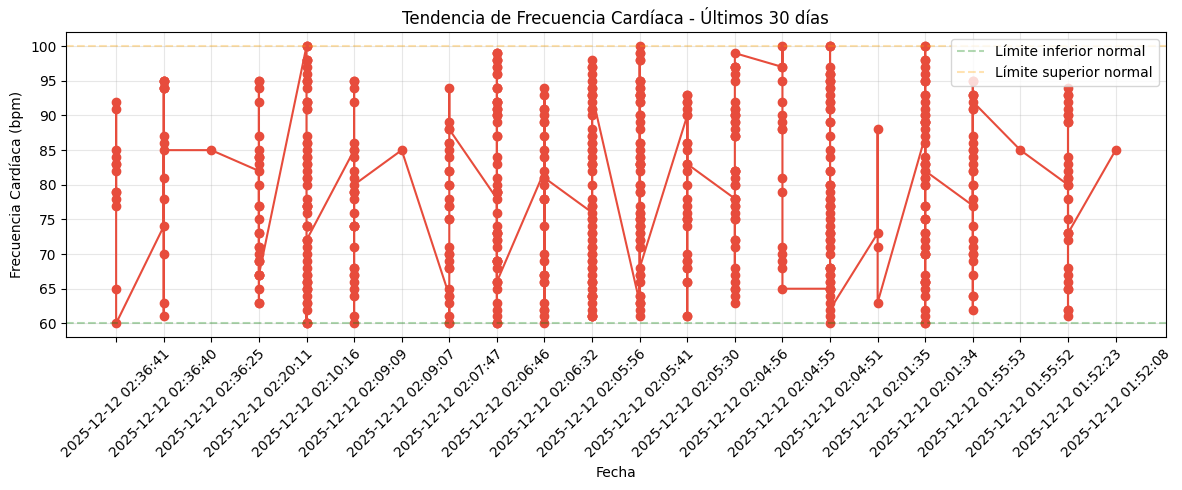

In [48]:
# Mostrar gráfica de frecuencia cardíaca
viz.grafica_frecuencia_cardiaca()

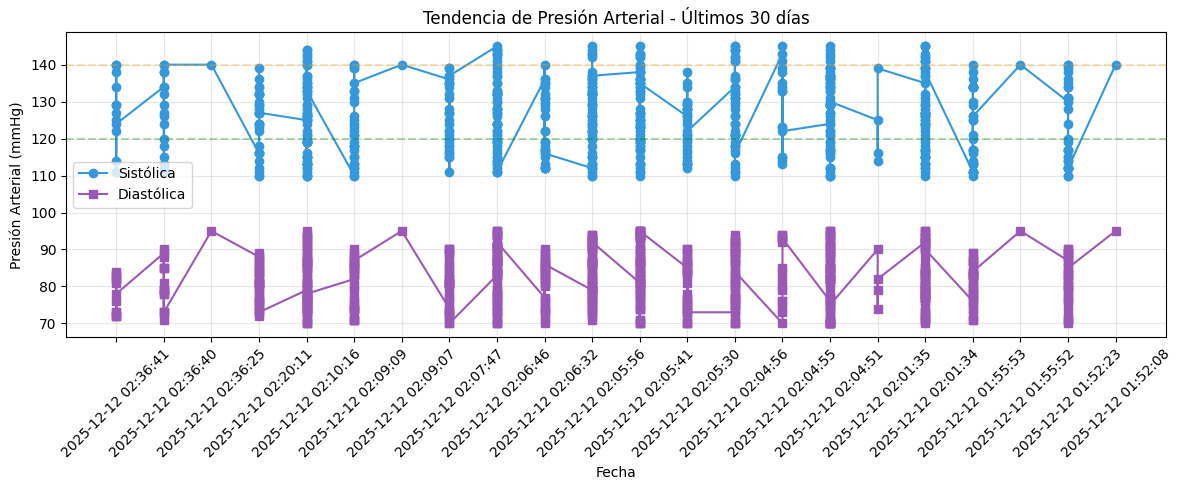

In [49]:
# Mostrar gráfica de presión arterial
viz.grafica_presion_arterial()

## Agente Conversacional con Memoria

Sistema de chat inteligente con contexto histórico usando LangChain Memory.

In [50]:
# Instalación de componentes adicionales de LangChain
!pip install langchain-community

Defaulting to user installation because normal site-packages is not writeable


In [51]:
from langchain_classic.memory import ConversationBufferMemory
from langchain_classic.chains import ConversationChain

class AgenteConversacional:
    """Agente de salud con memoria conversacional"""
    
    def __init__(self, llm, db: HealthDatabase, user_id: str):
        self.llm = llm
        self.db = db
        self.user_id = user_id
        
        # Configurar memoria
        self.memory = ConversationBufferMemory()
        
        # Crear cadena conversacional
        self.conversation = ConversationChain(
            llm=self.llm,
            memory=self.memory,
            verbose=False
        )
        
        # Inicializar con contexto del usuario
        self._cargar_contexto()
    
    def _cargar_contexto(self):
        """Cargar historial del usuario como contexto"""
        stats = self.db.obtener_estadisticas(self.user_id)
        
        if stats:
            contexto = f"""
            Eres un asistente médico virtual que ayuda a {self.user_id}.
            
            Historial reciente del usuario:
            - Frecuencia cardíaca promedio: {stats.get('frecuencia_cardiaca_promedio', 0):.1f} bpm
            - Presión arterial promedio: {stats.get('presion_sistolica_promedio', 0):.1f}/{stats.get('presion_diastolica_promedio', 0):.1f} mmHg
            - Pasos promedio diarios: {stats.get('pasos_promedio', 0):.0f}
            - Horas de sueño promedio: {stats.get('horas_sueno_promedio', 0):.1f}
            - Total de mediciones: {stats.get('total_mediciones', 0)}
            
            Mantén un tono amable y profesional. Recuerda al usuario que tus recomendaciones
            no sustituyen la consulta médica profesional.
            """
            
            self.memory.save_context(
                {"input": "Preséntate y muéstrame mi historial"},
                {"output": contexto}
            )
    
    def chatear(self, mensaje: str) -> str:
        """Interactuar con el agente"""
        respuesta = self.conversation.predict(input=mensaje)
        return respuesta
    
    def analizar_datos_actual(self, datos: WearableData) -> str:
        """Analizar datos actuales con contexto histórico"""
        mensaje = f"""
        Acabo de recibir nuevas mediciones:
        - Frecuencia Cardíaca: {datos.frecuencia_cardiaca} bpm
        - Presión Arterial: {datos.presion_sistolica}/{datos.presion_diastolica} mmHg
        - Nivel de Oxígeno: {datos.nivel_oxigeno}%
        - Pasos: {datos.pasos}
        - Calorías: {datos.calorias}
        - Horas de sueño: {datos.horas_sueno}
        
        Analiza estos datos comparándolos con mi historial y dame recomendaciones.
        """
        
        return self.chatear(mensaje)
    
    def obtener_historial_conversacion(self):
        """Ver el historial de la conversación"""
        return self.memory.load_memory_variables({})

# Crear agente conversacional
agente_chat = AgenteConversacional(llm, db, "user_12345")

print("=== AGENTE DE SALUD CONVERSACIONAL ===")
print("Escribe 'salir' para terminar la conversación\n")

=== AGENTE DE SALUD CONVERSACIONAL ===
Escribe 'salir' para terminar la conversación



In [52]:
# Ejemplo de conversación con el agente
preguntas = [
    "¿Cómo están mis valores de presión arterial?",
    "¿Debería preocuparme por mi frecuencia cardíaca?",
    "Dame consejos para mejorar mi sueño"
]

for pregunta in preguntas:
    print(f"Usuario: {pregunta}")
    respuesta = agente_chat.chatear(pregunta)
    print(f"Agente: {respuesta}\n")
    print("-" * 80 + "\n")

Usuario: ¿Cómo están mis valores de presión arterial?
Agente: Tus valores de presión arterial promedio recientemente registrados son 126.0/82.1 mmHg. Esto está dentro del rango normal, que es menos de 120/80 mmHg para la presión arterial sistólica/diastólica. Sin embargo, es importante recordar que estos valores pueden variar dependiendo de una serie de factores, incluyendo la actividad física, el estrés y la dieta. Como siempre, te recomendaría consultar a un profesional de la salud si tienes alguna preocupación.

--------------------------------------------------------------------------------

Usuario: ¿Debería preocuparme por mi frecuencia cardíaca?
Agente: Tus valores de presión arterial promedio recientemente registrados son 126.0/82.1 mmHg. Esto está dentro del rango normal, que es menos de 120/80 mmHg para la presión arterial sistólica/diastólica. Sin embargo, es importante recordar que estos valores pueden variar dependiendo de una serie de factores, incluyendo la actividad fís

In [53]:
# Analizar nuevos datos con contexto histórico
nuevos_datos = api.get_realtime_data()
print("=== NUEVAS MEDICIONES ===")
print(nuevos_datos.to_dict())
print("\n=== ANÁLISIS CON CONTEXTO ===")
analisis_contextual = agente_chat.analizar_datos_actual(nuevos_datos)
print(analisis_contextual)

=== NUEVAS MEDICIONES ===
{'frecuencia_cardiaca': 68, 'presion': '140/81', 'nivel_oxigeno': 98, 'pasos': 3553, 'calorias': 2015, 'horas_sueno': 5.6, 'timestamp': '2025-12-11 21:37:42'}

=== ANÁLISIS CON CONTEXTO ===
Basándome en tus mediciones más recientes en comparación con tu historial, aquí están mis observaciones y recomendaciones:

- Frecuencia cardíaca: Tu frecuencia cardíaca más reciente es de 68 latidos por minuto, lo cual es más bajo que tu promedio anterior de 79.5 latidos por minuto. Esto es una buena señal y puede indicar una mejora en tu estado físico y eficiencia cardíaca.

- Presión arterial: Tu presión arterial más reciente es de 140/81 mmHg, lo cual es un poco más alto que tu promedio anterior de 126.0/82.1 mmHg. Aunque la presión diastólica está dentro del rango normal, la presión sistólica está un poco elevada. Te recomendaría que sigas monitorizando tu presión arterial y consultes a un profesional de la salud si continúa siendo alta.

- Nivel de oxígeno: Tu nivel d

## Sistema de Notificaciones y Alertas

Notificaciones automáticas basadas en umbrales críticos de salud.

In [54]:
from enum import Enum
from dataclasses import dataclass
from typing import Callable

class NivelAlerta(Enum):
    """Niveles de alerta"""
    BAJO = "🟢 BAJO"
    MEDIO = "🟡 MEDIO"
    ALTO = "🔴 ALTO"
    CRITICO = "🚨 CRÍTICO"

@dataclass
class Notificacion:
    """Estructura de notificación"""
    nivel: NivelAlerta
    titulo: str
    mensaje: str
    timestamp: datetime
    datos_relacionados: Dict

class SistemaNotificaciones:
    """Sistema de alertas y notificaciones inteligentes"""
    
    def __init__(self):
        self.notificaciones = []
        self.callbacks = []
    
    def registrar_callback(self, callback: Callable):
        """Registrar función de callback para notificaciones"""
        self.callbacks.append(callback)
    
    def evaluar_datos(self, datos: WearableData) -> List[Notificacion]:
        """Evaluar datos y generar notificaciones"""
        notificaciones = []
        
        # Evaluar frecuencia cardíaca
        if datos.frecuencia_cardiaca > 120:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.CRITICO,
                titulo="Frecuencia Cardíaca Muy Alta",
                mensaje=f"Tu frecuencia cardíaca es {datos.frecuencia_cardiaca} bpm. Consulta a un médico inmediatamente.",
                timestamp=datetime.now(),
                datos_relacionados={'fc': datos.frecuencia_cardiaca}
            ))
        elif datos.frecuencia_cardiaca > 100:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.ALTO,
                titulo="Frecuencia Cardíaca Elevada",
                mensaje=f"Tu frecuencia cardíaca es {datos.frecuencia_cardiaca} bpm. Considera consultar a un médico.",
                timestamp=datetime.now(),
                datos_relacionados={'fc': datos.frecuencia_cardiaca}
            ))
        elif datos.frecuencia_cardiaca < 50:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.ALTO,
                titulo="Frecuencia Cardíaca Muy Baja",
                mensaje=f"Tu frecuencia cardíaca es {datos.frecuencia_cardiaca} bpm. Monitorea tu condición.",
                timestamp=datetime.now(),
                datos_relacionados={'fc': datos.frecuencia_cardiaca}
            ))
        
        # Evaluar presión arterial
        if datos.presion_sistolica >= 180 or datos.presion_diastolica >= 120:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.CRITICO,
                titulo="Crisis Hipertensiva",
                mensaje=f"Presión arterial: {datos.presion_sistolica}/{datos.presion_diastolica}. ¡Busca atención médica urgente!",
                timestamp=datetime.now(),
                datos_relacionados={'presion': f"{datos.presion_sistolica}/{datos.presion_diastolica}"}
            ))
        elif datos.presion_sistolica >= 140 or datos.presion_diastolica >= 90:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.MEDIO,
                titulo="Presión Arterial Elevada",
                mensaje=f"Presión arterial: {datos.presion_sistolica}/{datos.presion_diastolica}. Monitorea tu presión regularmente.",
                timestamp=datetime.now(),
                datos_relacionados={'presion': f"{datos.presion_sistolica}/{datos.presion_diastolica}"}
            ))
        
        # Evaluar nivel de oxígeno
        if datos.nivel_oxigeno < 90:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.CRITICO,
                titulo="Nivel de Oxígeno Crítico",
                mensaje=f"Nivel de oxígeno: {datos.nivel_oxigeno}%. Busca atención médica inmediata.",
                timestamp=datetime.now(),
                datos_relacionados={'oxigeno': datos.nivel_oxigeno}
            ))
        elif datos.nivel_oxigeno < 95:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.ALTO,
                titulo="Nivel de Oxígeno Bajo",
                mensaje=f"Nivel de oxígeno: {datos.nivel_oxigeno}%. Consulta a un médico.",
                timestamp=datetime.now(),
                datos_relacionados={'oxigeno': datos.nivel_oxigeno}
            ))
        
        # Evaluar sueño
        if datos.horas_sueno < 5:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.MEDIO,
                titulo="Sueño Insuficiente",
                mensaje=f"Solo dormiste {datos.horas_sueno} horas. Intenta dormir al menos 7-8 horas.",
                timestamp=datetime.now(),
                datos_relacionados={'sueno': datos.horas_sueno}
            ))
        
        # Evaluar actividad física
        if datos.pasos < 3000:
            notificaciones.append(Notificacion(
                nivel=NivelAlerta.BAJO,
                titulo="Actividad Física Baja",
                mensaje=f"Solo has dado {datos.pasos} pasos. Intenta alcanzar al menos 10,000 pasos diarios.",
                timestamp=datetime.now(),
                datos_relacionados={'pasos': datos.pasos}
            ))
        
        # Guardar y disparar callbacks
        self.notificaciones.extend(notificaciones)
        for notif in notificaciones:
            self._disparar_callbacks(notif)
        
        return notificaciones
    
    def _disparar_callbacks(self, notificacion: Notificacion):
        """Ejecutar callbacks registrados"""
        for callback in self.callbacks:
            try:
                callback(notificacion)
            except Exception as e:
                print(f"Error en callback: {e}")
    
    def obtener_notificaciones_recientes(self, horas: int = 24) -> List[Notificacion]:
        """Obtener notificaciones recientes"""
        limite_tiempo = datetime.now() - timedelta(hours=horas)
        return [n for n in self.notificaciones if n.timestamp > limite_tiempo]
    
    def limpiar_notificaciones(self):
        """Limpiar notificaciones antiguas"""
        self.notificaciones = []

# Callback de ejemplo
def callback_email(notificacion: Notificacion):
    """Simular envío de email en alertas críticas"""
    if notificacion.nivel in [NivelAlerta.CRITICO, NivelAlerta.ALTO]:
        print(f"EMAIL ENVIADO: {notificacion.titulo}")

# Crear sistema de notificaciones
sistema_notif = SistemaNotificaciones()
sistema_notif.registrar_callback(callback_email)

# Probar con datos críticos
datos_criticos = WearableData(
    frecuencia_cardiaca=125,
    presion_sistolica=185,
    presion_diastolica=100,
    nivel_oxigeno=92,
    pasos=2000,
    calorias=1600,
    horas_sueno=4.5
)

print("=== EVALUANDO DATOS CRÍTICOS ===\n")
alertas = sistema_notif.evaluar_datos(datos_criticos)

for alerta in alertas:
    print(f"{alerta.nivel.value}")
    print(f"Título: {alerta.titulo}")
    print(f"Mensaje: {alerta.mensaje}")
    print(f"Timestamp: {alerta.timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
    print("-" * 80)

=== EVALUANDO DATOS CRÍTICOS ===

EMAIL ENVIADO: Frecuencia Cardíaca Muy Alta
EMAIL ENVIADO: Crisis Hipertensiva
EMAIL ENVIADO: Nivel de Oxígeno Bajo
🚨 CRÍTICO
Título: Frecuencia Cardíaca Muy Alta
Mensaje: Tu frecuencia cardíaca es 125 bpm. Consulta a un médico inmediatamente.
Timestamp: 2025-12-11 21:38:12
--------------------------------------------------------------------------------
🚨 CRÍTICO
Título: Crisis Hipertensiva
Mensaje: Presión arterial: 185/100. ¡Busca atención médica urgente!
Timestamp: 2025-12-11 21:38:12
--------------------------------------------------------------------------------
🔴 ALTO
Título: Nivel de Oxígeno Bajo
Mensaje: Nivel de oxígeno: 92%. Consulta a un médico.
Timestamp: 2025-12-11 21:38:12
--------------------------------------------------------------------------------
🟡 MEDIO
Título: Sueño Insuficiente
Mensaje: Solo dormiste 4.5 horas. Intenta dormir al menos 7-8 horas.
Timestamp: 2025-12-11 21:38:12
------------------------------------------------------

## Exportación de Reportes PDF

Generación de reportes médicos profesionales en formato PDF.

In [55]:
# Instalación de librerías para PDF
!pip install reportlab matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [56]:
from reportlab.lib.pagesizes import letter, A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.enums import TA_CENTER, TA_LEFT
import io

class GeneradorReportesPDF:
    """Generador de reportes médicos en PDF"""
    
    def __init__(self, db: HealthDatabase, user_id: str):
        self.db = db
        self.user_id = user_id
        self.styles = getSampleStyleSheet()
        self._configurar_estilos()
    
    def _configurar_estilos(self):
        """Configurar estilos personalizados"""
        self.styles.add(ParagraphStyle(
            name='CustomTitle',
            parent=self.styles['Heading1'],
            fontSize=24,
            textColor=colors.HexColor('#2c3e50'),
            spaceAfter=30,
            alignment=TA_CENTER
        ))
        
        self.styles.add(ParagraphStyle(
            name='CustomHeading',
            parent=self.styles['Heading2'],
            fontSize=16,
            textColor=colors.HexColor('#3498db'),
            spaceAfter=12,
            spaceBefore=12
        ))
    
    def _crear_grafica_tendencias(self) -> str:
        """Crear gráfica de tendencias y retornar path"""
        df = self.db.obtener_historial(self.user_id, dias=30)
        
        if df.empty:
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        fig.suptitle('Tendencias de Salud - Últimos 30 Días', fontsize=16)
        
        # Frecuencia cardíaca
        axes[0, 0].plot(df['timestamp'], df['frecuencia_cardiaca'], color='#e74c3c', marker='o')
        axes[0, 0].set_title('Frecuencia Cardíaca')
        axes[0, 0].set_ylabel('bpm')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Presión arterial
        axes[0, 1].plot(df['timestamp'], df['presion_sistolica'], label='Sistólica', color='#3498db', marker='o')
        axes[0, 1].plot(df['timestamp'], df['presion_diastolica'], label='Diastólica', color='#9b59b6', marker='s')
        axes[0, 1].set_title('Presión Arterial')
        axes[0, 1].set_ylabel('mmHg')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Pasos
        axes[1, 0].bar(range(len(df)), df['pasos'], color='#2ecc71')
        axes[1, 0].set_title('Actividad Física')
        axes[1, 0].set_ylabel('Pasos')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Sueño
        axes[1, 1].plot(df['timestamp'], df['horas_sueno'], color='#f39c12', marker='o')
        axes[1, 1].set_title('Calidad del Sueño')
        axes[1, 1].set_ylabel('Horas')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Guardar temporalmente
        temp_path = f'temp_grafica_{self.user_id}.png'
        plt.savefig(temp_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        return temp_path
    
    def generar_reporte(self, filename: str = None, incluir_analisis_ia: bool = True):
        """Generar reporte completo en PDF"""
        if filename is None:
            filename = f'reporte_salud_{self.user_id}_{datetime.now().strftime("%Y%m%d")}.pdf'
        
        # Crear documento
        doc = SimpleDocTemplate(filename, pagesize=letter)
        elements = []
        
        # Título
        titulo = Paragraph("REPORTE MÉDICO DE SALUD", self.styles['CustomTitle'])
        elements.append(titulo)
        elements.append(Spacer(1, 0.3*inch))
        
        # Información del paciente
        info_paciente = f"""
        <b>Usuario:</b> {self.user_id}<br/>
        <b>Fecha del reporte:</b> {datetime.now().strftime('%d/%m/%Y %H:%M')}<br/>
        <b>Período analizado:</b> Últimos 30 días
        """
        elements.append(Paragraph(info_paciente, self.styles['Normal']))
        elements.append(Spacer(1, 0.3*inch))
        
        # Estadísticas
        elements.append(Paragraph("RESUMEN ESTADÍSTICO", self.styles['CustomHeading']))
        
        stats = self.db.obtener_estadisticas(self.user_id)
        
        if stats:
            data_stats = [
                ['Métrica', 'Valor Promedio', 'Estado'],
                ['Frecuencia Cardíaca', f"{stats.get('frecuencia_cardiaca_promedio', 0):.1f} bpm", 
                 self._evaluar_fc(stats.get('frecuencia_cardiaca_promedio', 0))],
                ['Presión Sistólica', f"{stats.get('presion_sistolica_promedio', 0):.1f} mmHg",
                 self._evaluar_presion_sist(stats.get('presion_sistolica_promedio', 0))],
                ['Presión Diastólica', f"{stats.get('presion_diastolica_promedio', 0):.1f} mmHg",
                 self._evaluar_presion_diast(stats.get('presion_diastolica_promedio', 0))],
                ['Pasos Diarios', f"{stats.get('pasos_promedio', 0):.0f} pasos",
                 self._evaluar_pasos(stats.get('pasos_promedio', 0))],
                ['Horas de Sueño', f"{stats.get('horas_sueno_promedio', 0):.1f} horas",
                 self._evaluar_sueno(stats.get('horas_sueno_promedio', 0))],
            ]
            
            tabla_stats = Table(data_stats, colWidths=[2.5*inch, 2*inch, 2*inch])
            tabla_stats.setStyle(TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#3498db')),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('FONTSIZE', (0, 0), (-1, 0), 12),
                ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ]))
            
            elements.append(tabla_stats)
            elements.append(Spacer(1, 0.3*inch))
        
        # Gráficas
        elements.append(Paragraph("TENDENCIAS VISUALES", self.styles['CustomHeading']))
        
        grafica_path = self._crear_grafica_tendencias()
        if grafica_path:
            img = Image(grafica_path, width=6.5*inch, height=5.2*inch)
            elements.append(img)
            elements.append(Spacer(1, 0.3*inch))
        
        # Análisis con IA (opcional)
        if incluir_analisis_ia:
            elements.append(PageBreak())
            elements.append(Paragraph("ANÁLISIS INTELIGENTE CON IA", self.styles['CustomHeading']))
            
            # Obtener último análisis
            df = self.db.obtener_historial(self.user_id, dias=1)
            if not df.empty:
                ultimo_dato = df.iloc[0]
                datos_recientes = WearableData(
                    frecuencia_cardiaca=int(ultimo_dato['frecuencia_cardiaca']),
                    presion_sistolica=int(ultimo_dato['presion_sistolica']),
                    presion_diastolica=int(ultimo_dato['presion_diastolica']),
                    nivel_oxigeno=int(ultimo_dato['nivel_oxigeno']),
                    pasos=int(ultimo_dato['pasos']),
                    calorias=int(ultimo_dato['calorias']),
                    horas_sueno=float(ultimo_dato['horas_sueno'])
                )
                
                try:
                    analisis_ia = analizar_datos_salud(datos_recientes)
                    elements.append(Paragraph(analisis_ia.replace('\n', '<br/>'), self.styles['Normal']))
                except Exception as e:
                    elements.append(Paragraph(f"No se pudo generar análisis IA: {str(e)}", self.styles['Normal']))
        
        # Disclaimer
        elements.append(Spacer(1, 0.5*inch))
        disclaimer = """
        <b>AVISO IMPORTANTE:</b> Este reporte es generado automáticamente con fines informativos. 
        Los datos y análisis presentados NO sustituyen la evaluación médica profesional. 
        Consulte siempre a un médico certificado para diagnósticos y tratamientos.
        """
        elements.append(Paragraph(disclaimer, self.styles['Normal']))
        
        # Construir PDF
        doc.build(elements)
        
        print(f"Reporte PDF generado: {filename}")
        
        # Limpiar archivos temporales
        if grafica_path:
            import os
            try:
                os.remove(grafica_path)
            except:
                pass
        
        return filename
    
    def _evaluar_fc(self, valor):
        if 60 <= valor <= 100:
            return "✓ Normal"
        elif valor > 100:
            return "⚠ Elevada"
        else:
            return "⚠ Baja"
    
    def _evaluar_presion_sist(self, valor):
        if valor < 120:
            return "✓ Normal"
        elif valor < 140:
            return "⚠ Elevada"
        else:
            return "✗ Alta"
    
    def _evaluar_presion_diast(self, valor):
        if valor < 80:
            return "✓ Normal"
        elif valor < 90:
            return "⚠ Elevada"
        else:
            return "✗ Alta"
    
    def _evaluar_pasos(self, valor):
        if valor >= 10000:
            return "✓ Excelente"
        elif valor >= 7000:
            return "✓ Bueno"
        else:
            return "⚠ Bajo"
    
    def _evaluar_sueno(self, valor):
        if 7 <= valor <= 9:
            return "✓ Óptimo"
        elif valor < 7:
            return "⚠ Insuficiente"
        else:
            return "⚠ Excesivo"

# Generar reporte PDF
generador_pdf = GeneradorReportesPDF(db, "user_12345")
archivo_pdf = generador_pdf.generar_reporte(incluir_analisis_ia=False)  # Cambiar a True si tienes API key
print(f"\nReporte guardado como: {archivo_pdf}")

Reporte PDF generado: reporte_salud_user_12345_20251211.pdf

Reporte guardado como: reporte_salud_user_12345_20251211.pdf


## Sistema Completo Integrado

Aplicación completa que integra todos los componentes en un sistema unificado.

In [57]:
class SistemaSaludIntegrado:
    """Sistema completo de monitoreo de salud con IA"""
    
    def __init__(self, user_id: str, api_key: str = None):
        self.user_id = user_id
        
        # Inicializar componentes
        self.api_wearable = WearableAPI(user_id)
        self.db = HealthDatabase()
        self.sistema_notif = SistemaNotificaciones()
        self.visualizador = HealthVisualizer(self.db, user_id)
        self.generador_pdf = GeneradorReportesPDF(self.db, user_id)
        
        # Configurar LLM si hay API key
        if api_key:
            self.llm = ChatOpenAI(
                model="gpt-4",
                temperature=0.3,
                openai_api_key=api_key
            )
            self.agente = AgenteConversacional(self.llm, self.db, user_id)
        else:
            self.llm = None
            self.agente = None
        
        # Configurar callbacks
        self.sistema_notif.registrar_callback(self._callback_alerta_critica)
    
    def _callback_alerta_critica(self, notificacion: Notificacion):
        """Callback para alertas críticas"""
        if notificacion.nivel == NivelAlerta.CRITICO:
            print(f"\n🚨 ALERTA CRÍTICA: {notificacion.titulo}")
            print(f"   {notificacion.mensaje}\n")
    
    def monitoreo_continuo(self, intervalo_segundos: int = 60, duracion_minutos: int = 5):
        """Simular monitoreo continuo"""
        print(f" Iniciando monitoreo continuo para {self.user_id}")
        print(f"   Intervalo: {intervalo_segundos}s | Duración: {duracion_minutos}min\n")
        
        iteraciones = (duracion_minutos * 60) // intervalo_segundos
        
        for i in range(iteraciones):
            print(f"--- Medición {i+1}/{iteraciones} ---")
            
            # Obtener datos del wearable
            datos = self.api_wearable.get_realtime_data()
            print(f"Datos: FC={datos.frecuencia_cardiaca} bpm, "
                  f"PA={datos.presion_sistolica}/{datos.presion_diastolica}, "
                  f"SpO2={datos.nivel_oxigeno}%")
            
            # Guardar en base de datos
            medicion_id = self.db.guardar_medicion(self.user_id, datos)
            
            # Evaluar alertas
            alertas = self.sistema_notif.evaluar_datos(datos)
            if alertas:
                print(f"  {len(alertas)} alertas generadas")
            
            print(f"✓ Medición guardada (ID: {medicion_id})\n")
            
            # Simular espera (en producción usaríamos time.sleep)
            # time.sleep(intervalo_segundos)
        
        print(" Monitoreo completado\n")
    
    def generar_reporte_completo(self):
        """Generar reporte PDF completo"""
        print(" Generando reporte completo...")
        filename = self.generador_pdf.generar_reporte(incluir_analisis_ia=(self.llm is not None))
        return filename
    
    def mostrar_dashboard(self):
        """Mostrar dashboard visual"""
        print(" Generando dashboard...")
        self.visualizador.dashboard_interactivo()
    
    def chat_con_agente(self, mensaje: str) -> str:
        """Chatear con el agente de IA"""
        if not self.agente:
            return " Agente de IA no disponible. Configure OPENAI_API_KEY."
        
        return self.agente.chatear(mensaje)
    
    def resumen_estado(self):
        """Mostrar resumen del estado actual"""
        print("=" * 80)
        print(f" SISTEMA DE SALUD - Usuario: {self.user_id}")
        print("=" * 80)
        
        # Información del dispositivo
        device_info = self.api_wearable.get_device_info()
        print(f"\n🔹 Dispositivo: {device_info['device']}")
        print(f"🔹 Batería: {device_info['battery']}")
        print(f"🔹 Última sincronización: {device_info['last_sync']}")
        
        # Estadísticas
        stats = self.db.obtener_estadisticas(self.user_id)
        if stats:
            print(f"\n ESTADÍSTICAS (últimos 30 días):")
            print(f"   • Mediciones totales: {stats['total_mediciones']}")
            print(f"   • FC promedio: {stats['frecuencia_cardiaca_promedio']:.1f} bpm")
            print(f"   • PA promedio: {stats['presion_sistolica_promedio']:.0f}/{stats['presion_diastolica_promedio']:.0f} mmHg")
            print(f"   • Pasos promedio: {stats['pasos_promedio']:.0f}")
            print(f"   • Sueño promedio: {stats['horas_sueno_promedio']:.1f} horas")
        
        # Notificaciones recientes
        notif_recientes = self.sistema_notif.obtener_notificaciones_recientes(horas=24)
        if notif_recientes:
            print(f"\n  ALERTAS RECIENTES (últimas 24h): {len(notif_recientes)}")
            criticas = sum(1 for n in notif_recientes if n.nivel == NivelAlerta.CRITICO)
            if criticas > 0:
                print(f"   🚨 {criticas} alertas críticas")
        
        print("\n" + "=" * 80)
    
    def demo_completo(self):
        """Ejecutar demostración completa del sistema"""
        print("\n" + " " * 20)
        print("DEMOSTRACIÓN COMPLETA DEL SISTEMA DE SALUD INTELIGENTE")
        print(" " * 20 + "\n")
        
        # 1. Resumen inicial
        print("\n  PASO 1: Resumen del Estado")
        print("-" * 80)
        self.resumen_estado()
        
        # 2. Monitoreo simulado
        print("\n PASO 2: Monitoreo Continuo (simulado)")
        print("-" * 80)
        self.monitoreo_continuo(intervalo_segundos=1, duracion_minutos=1)
        
        # 3. Dashboard
        print("\n  PASO 3: Dashboard Visual")
        print("-" * 80)
        self.mostrar_dashboard()
        
        # 4. Reporte PDF
        print("\n PASO 4: Generación de Reporte PDF")
        print("-" * 80)
        self.generar_reporte_completo()
        
        # 5. Chat con IA (si está disponible)
        if self.agente:
            print("\n  PASO 5: Consulta con Agente de IA")
            print("-" * 80)
            respuesta = self.chat_con_agente("¿Cómo está mi salud en general?")
            print(f" Agente: {respuesta}")
        
        print("\n" + " " * 20)
        print("DEMOSTRACIÓN COMPLETADA")
        print(" " * 20 + "\n")

# Crear sistema integrado
# Para usar con OpenAI, descomentar y agregar tu API key:
# sistema = SistemaSaludIntegrado("user_12345", api_key=os.getenv('OPENAI_API_KEY'))

# Sin OpenAI (solo funcionalidades básicas):
sistema = SistemaSaludIntegrado("user_12345")

print(" Sistema de Salud Integrado inicializado")
print("  Use: sistema.demo_completo() para ver todas las funcionalidades")

 Sistema de Salud Integrado inicializado
  Use: sistema.demo_completo() para ver todas las funcionalidades


In [58]:
# Ejecutar demostración completa del sistema
sistema.demo_completo()


                    
DEMOSTRACIÓN COMPLETA DEL SISTEMA DE SALUD INTELIGENTE
                    


  PASO 1: Resumen del Estado
--------------------------------------------------------------------------------
 SISTEMA DE SALUD - Usuario: user_12345

🔹 Dispositivo: Samsung Galaxy Watch
🔹 Batería: 67%
🔹 Última sincronización: 2025-12-11 21:39:21

 ESTADÍSTICAS (últimos 30 días):
   • Mediciones totales: 664
   • FC promedio: 79.5 bpm
   • PA promedio: 126/82 mmHg
   • Pasos promedio: 7748
   • Sueño promedio: 6.9 horas


 PASO 2: Monitoreo Continuo (simulado)
--------------------------------------------------------------------------------
 Iniciando monitoreo continuo para user_12345
   Intervalo: 1s | Duración: 1min

--- Medición 1/60 ---
Datos: FC=76 bpm, PA=115/81, SpO2=97%
✓ Medición guardada (ID: 686)

--- Medición 2/60 ---
Datos: FC=61 bpm, PA=143/74, SpO2=96%
  1 alertas generadas
✓ Medición guardada (ID: 687)

--- Medición 3/60 ---
Datos: FC=72 bpm, PA=116/80, SpO2=98%
  1 alert


 PASO 4: Generación de Reporte PDF
--------------------------------------------------------------------------------
 Generando reporte completo...
Reporte PDF generado: reporte_salud_user_12345_20251211.pdf

                    
DEMOSTRACIÓN COMPLETADA
                    

Reporte PDF generado: reporte_salud_user_12345_20251211.pdf

                    
DEMOSTRACIÓN COMPLETADA
                    



---

# 💡 PARTE 3: Casos de Uso Prácticos

Ejemplos reales de aplicación del sistema en diferentes escenarios médicos.

In [ ]:
# Caso 1: Detección de Arritmia con IA
print("=" * 80)
print("CASO 1: DETECCIÓN DE ARRITMIA CON ANÁLISIS DE IA")
print("=" * 80)

datos_arritmia = WearableData(
    frecuencia_cardiaca=145,  # Taquicardia
    presion_sistolica=135,
    presion_diastolica=88,
    nivel_oxigeno=96,
    pasos=8500,
    calorias=2100,
    horas_sueno=7.0
)

print("\n📊 Datos del paciente:")
print(f"   FC: {datos_arritmia.frecuencia_cardiaca} bpm (muy elevada)")
print(f"   PA: {datos_arritmia.presion_sistolica}/{datos_arritmia.presion_diastolica} mmHg")
print(f"   SpO2: {datos_arritmia.nivel_oxigeno}%")
print(f"   Pasos: {datos_arritmia.pasos:,}")
print(f"   Sueño: {datos_arritmia.horas_sueno} horas")

# Análisis automático de alertas
alertas = verificar_alertas(datos_arritmia)
print(f"\n⚠️  Alertas generadas: {len(alertas)}")

for alerta in alertas:print("\n" + "=" * 80 + "\n")

    print(f"   {alerta}")

    print("💡 Asegúrate de tener configurada tu OPENAI_API_KEY en el archivo .env")

# Análisis con IA    print(f"❌ Error al generar análisis con IA: {e}")

print("\n🤖 ANÁLISIS CON INTELIGENCIA ARTIFICIAL:")except Exception as e:

print("-" * 80)    print(analisis_ia)

try:    analisis_ia = analizar_datos_salud(datos_arritmia)

CASO 1: DETECCIÓN DE ARRITMIA

📊 Datos del paciente:
   FC: 145 bpm (muy elevada)
   PA: 135/88 mmHg

⚠️  Alertas generadas: 1
   ⚠️ Frecuencia cardíaca fuera de rango: 145 bpm

💡 Recomendación: Consulta médica urgente para evaluación cardiológica



In [59]:
# Caso 2: Monitoreo de Hipertensión con IA
print("=" * 80)
print("CASO 2: SEGUIMIENTO DE HIPERTENSIÓN CON ANÁLISIS DE IA")
print("=" * 80)

# Simular serie temporal de presión arterial
print("\n Tendencia de presión arterial en la última semana:\n")

dias_semana = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
presiones_sist = [138, 142, 145, 140, 138, 135, 132]
presiones_diast = [92, 94, 96, 93, 90, 88, 85]

for i, dia in enumerate(dias_semana):
    datos_dia = WearableData(
        frecuencia_cardiaca=random.randint(70, 85),
        presion_sistolica=presiones_sist[i],
        presion_diastolica=presiones_diast[i],
        nivel_oxigeno=98,
        pasos=random.randint(6000, 10000),
        calorias=2000,
        horas_sueno=7.5
    )
    
    sistema.db.guardar_medicion("paciente_hipertenso", datos_dia)
    
    estado = " ALTA" if presiones_sist[i] >= 140 or presiones_diast[i] >= 90 else "✓ Normal"
    print(f"   {dia}: {presiones_sist[i]}/{presiones_diast[i]} mmHg - {estado}")

# Análisis con IA del último día
print("\n" + "=" * 80 + "\n")
print("\n ANÁLISIS CON INTELIGENCIA ARTIFICIAL (último dato):")

ultimo_dato = WearableData(
    frecuencia_cardiaca=random.randint(70, 85),
    presion_sistolica=presiones_sist[-1],
    presion_diastolica=presiones_diast[-1],
    nivel_oxigeno=98,
    pasos=8000,
    calorias=2000,
    horas_sueno=7.5
)

try:
    analisis_ia = analizar_datos_salud(ultimo_dato)
    print(analisis_ia)

except Exception as e:
    print(" Error al generar análisis con IA:", str(e))
    print(" Asegúrate de tener configurada tu OPENAI_API_KEY en el archivo .env")

print("-" * 80)


CASO 2: SEGUIMIENTO DE HIPERTENSIÓN CON ANÁLISIS DE IA

 Tendencia de presión arterial en la última semana:

   Lun: 138/92 mmHg -  ALTA
   Mar: 142/94 mmHg -  ALTA
   Mié: 145/96 mmHg -  ALTA
   Jue: 140/93 mmHg -  ALTA
   Vie: 138/90 mmHg -  ALTA
   Sáb: 135/88 mmHg - ✓ Normal
   Dom: 132/85 mmHg - ✓ Normal



 ANÁLISIS CON INTELIGENCIA ARTIFICIAL (último dato):
1. **Estado General**: Los indicadores vitales parecen estar en un rango saludable. La frecuencia cardíaca está dentro del rango normal para un adulto en reposo (60-100 bpm). La presión arterial es ligeramente alta, pero aún dentro de los límites aceptables. El nivel de oxígeno en sangre es excelente, y la cantidad de pasos del día indica un buen nivel de actividad física. Las calorías consumidas parecen estar en línea con una dieta balanceada, y las horas de sueño cumplen con las recomendaciones generales para adultos.

2. **Alertas**: La única alerta sería la presión arterial, que aunque está dentro de los límites aceptable

In [60]:
# Caso 3: Optimización de Rendimiento Deportivo con IA
print("=" * 80)
print("CASO 3: OPTIMIZACIÓN DEPORTIVA CON ANÁLISIS DE IA")
print("=" * 80)

# Datos simulados del atleta
datos_atleta = WearableData(
    frecuencia_cardiaca=155,   # Durante ejercicio intenso
    presion_sistolica=145,
    presion_diastolica=75,
    nivel_oxigeno=97,
    pasos=18500,               # Entrenamiento intenso
    calorias=3200,
    horas_sueno=8.5
)

print("\n Perfil de atleta en entrenamiento intenso:")
print(f"   FC actual: {datos_atleta.frecuencia_cardiaca} bpm")
print(f"   PA: {datos_atleta.presion_sistolica}/{datos_atleta.presion_diastolica} mmHg")
print(f"   SpO2: {datos_atleta.nivel_oxigeno}%")
print(f"   Pasos: {datos_atleta.pasos:,}")
print(f"   Calorías quemadas: {datos_atleta.calorias}")
print(f"   Calidad de sueño: {datos_atleta.horas_sueno} horas")

# Calcular zona de entrenamiento
edad_estimada = 25
fc_max_teorica = 220 - edad_estimada
zona_actual = (datos_atleta.frecuencia_cardiaca / fc_max_teorica) * 100

print(f"\n Análisis de zona de entrenamiento:")
print(f"   FC máxima teórica: {fc_max_teorica} bpm")
print(f"   Zona actual: {zona_actual:.1f}% de FC máxima")

if 70 <= zona_actual <= 85:
    print("    ZONA AERÓBICA - Ideal para resistencia")
elif 85 <= zona_actual <= 95:
    print("    ZONA ANAERÓBICA - Mejora rendimiento")
else:
    print("    ZONA DE ALTA INTENSIDAD - Monitorear cuidadosamente")

print("\n" + "=" * 80 + "\n")

# Análisis con IA
print(" ANÁLISIS CON INTELIGENCIA ARTIFICIAL:")

try:
    analisis_ia = analizar_datos_salud(datos_atleta)
    print(analisis_ia)

except Exception as e:
    print(f" Error al generar análisis con IA: {e}")
    print(" Asegúrate de tener configurada tu OPENAI_API_KEY en el archivo .env")

print("-" * 80)


CASO 3: OPTIMIZACIÓN DEPORTIVA CON ANÁLISIS DE IA

 Perfil de atleta en entrenamiento intenso:
   FC actual: 155 bpm
   PA: 145/75 mmHg
   SpO2: 97%
   Pasos: 18,500
   Calorías quemadas: 3200
   Calidad de sueño: 8.5 horas

 Análisis de zona de entrenamiento:
   FC máxima teórica: 195 bpm
   Zona actual: 79.5% de FC máxima
    ZONA AERÓBICA - Ideal para resistencia


 ANÁLISIS CON INTELIGENCIA ARTIFICIAL:
1. **Estado General**: Los indicadores vitales muestran una frecuencia cardíaca y presión arterial elevadas. El nivel de oxígeno está dentro del rango normal, y la cantidad de pasos y calorías consumidas indican un alto nivel de actividad física. Las horas de sueño están dentro del rango recomendado.

2. **Alertas**: La frecuencia cardíaca de 155 bpm está por encima del rango normal (60-100 bpm para adultos en reposo), lo que puede indicar un esfuerzo físico intenso, estrés o un problema de salud. La presión arterial sistólica (145 mmHg) también está elevada (normal es menos de 120 m